In [185]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

##### Q1
load the ”Sleep Efficiency.csv” file into Pandas

In [186]:
sleep = pd.read_csv('./Sleep_Efficiency.csv')

In [187]:
sleep['Smoking status'][0]

'Yes'

In [188]:
sleep['Smoking status'] = np.where(sleep['Smoking status'].values == 'Yes',1,0)

##### Q2 
how many different entries are there for each column.

In [189]:
sleep.describe()

,ID,Age,Sleep duration,Sleep efficiency,REM sleep percentage,Deep sleep percentage,Light sleep percentage,Awakenings,Caffeine consumption,Alcohol consumption,Smoking status,Exercise frequency
count,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,432.000000,427.000000,436.000000,452.000000,446.000000
mean,226.500000,40.285398,7.465708,0.788916,23.002212,52.960177,24.831858,1.641204,23.653396,1.245413,0.356195,1.791480
std,130.625419,13.172250,0.866625,0.135237,3.972466,15.561713,15.150774,1.356762,30.202785,1.643336,0.479404,1.428134
min,1.000000,9.000000,5.000000,0.500000,15.000000,20.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,113.750000,29.000000,7.000000,0.697500,20.000000,51.250000,15.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,226.500000,40.000000,7.500000,0.820000,22.000000,60.000000,18.000000,1.000000,25.000000,0.000000,0.000000,2.000000
75%,339.250000,52.000000,8.000000,0.900000,27.000000,63.000000,27.250000,3.000000,50.000000,2.000000,1.000000,3.000000
max,452.000000,69.000000,10.000000,0.990000,30.000000,75.000000,56.000000,4.000000,200.000000,5.000000,1.000000,5.000000


All columns have 452 observations except for awakening (432), Caffeine Cons. (427), Alcohol Cons. (436), and Exercise Freq. (446)

##### Q3 
how many entries are missing for each column

In [190]:
452 - sleep.describe().loc['count']

ID                         0.0
Age                        0.0
Sleep duration             0.0
Sleep efficiency           0.0
REM sleep percentage       0.0
Deep sleep percentage      0.0
Light sleep percentage     0.0
Awakenings                20.0
Caffeine consumption      25.0
Alcohol consumption       16.0
Smoking status             0.0
Exercise frequency         6.0
Name: count, dtype: float64

In [191]:
sum(sleep.isna().sum()) # There are 67 individual sleeppoints that are missing

67

In [192]:
sleep.isna().sum(axis=1).value_counts() # one person is missing two sleeppoints

0    386
1     65
2      1
Name: count, dtype: int64

In [193]:
sum(sleep.isna().sum(axis=1)>0) # 66 Individuals have missing sleep

66

In [194]:
missing_features = sleep.loc[:,sleep.isna().sum()!=0].columns.values
missing_features

array(['Awakenings', 'Caffeine consumption', 'Alcohol consumption',
       'Exercise frequency'], dtype=object)

Awakenings is missing 20 observations, Caffeine 25, Alcohol 16, and Exercise 6.  All other columns have no missing values.

##### Q4
for each missing entry, impute the missing values using the
following procedure:\
a) find 5 people with the same gender with the closest age
(”neighbors”)\
b) compute the average of these ”neighbors” as the value

Steps: 
1) find columns with missing values.
2) get indices of missing values and for each missing value and store missing column indices:
    a) get 5 closest same-sex neighbors by age and store their info for missing values.
    b) average and impute

Outer loop: missing features
inner loop (per feature): missing observations

In [195]:
def neighbors(data, feature, impute_dict):
    """args: dataFrame with missing values, the feature to be imputed,
    and the dictionary in which to store the imputed values"""
    data = data[['Age','ID','Gender',feature]]
    miss_feat = data[data[feature].isna()]
    miss_feat_m = miss_feat[miss_feat.Gender == 'Male']
    miss_feat_f = miss_feat[miss_feat.Gender == 'Female']
    has_feat_mask = ~data.index.isin(miss_feat.index)
    others_m = data[np.bitwise_and(has_feat_mask,data.Gender=='Male')]
    others_f = data[np.bitwise_and(has_feat_mask,data.Gender=='Female')]
    for sex in ['Male','Female']:
        if sex == 'Female':
            for inx in miss_feat_f.index:   
                age_diff = others_f.Age - miss_feat_f['Age'][inx]
                
                nearest_inx = age_diff.abs().sort_values()[0:5].index
                nearest_mean = others_f[feature][nearest_inx].values.mean()
                if inx in impute_dict:
                    impute_dict[inx] = impute_dict[inx].update({feature:
                                                    (nearest_mean,nearest_inx)})
                    
                else:
                    impute_dict[inx] = {feature: (nearest_mean,nearest_inx)}
        else:
            for inx in miss_feat_m.index:
                age_diff = others_m.Age - miss_feat_m['Age'][inx]
                nearest_inx = age_diff.abs().sort_values()[0:5].index
                nearest_mean = others_m[feature][nearest_inx].values.mean()
                if inx in impute_dict:
                    impute_dict[inx].update({feature:
                                                    (nearest_mean,nearest_inx)})
                else:
                    impute_dict[inx] = {feature: (nearest_mean,nearest_inx)}
    return impute_dict

In [196]:
full_impute_dict = {}
for feature in missing_features:
    full_impute_dict.update(neighbors(sleep,feature,full_impute_dict))

In [197]:
full_impute_dict

{19: {'Awakenings': (1.0, Index([222, 67, 366, 199, 41], dtype='int64'))},
 85: {'Awakenings': (1.4, Index([233, 340, 7, 97, 344], dtype='int64'))},
 123: {'Awakenings': (2.0, Index([424, 54, 31, 451, 65], dtype='int64'))},
 138: {'Awakenings': (1.4, Index([420, 72, 11, 438, 80], dtype='int64'))},
 143: {'Awakenings': (2.0, Index([125, 345, 321, 439, 313], dtype='int64'))},
 170: {'Awakenings': (2.0, Index([30, 444, 192, 266, 20], dtype='int64'))},
 249: {'Awakenings': (1.2, Index([379, 210, 209, 200, 155], dtype='int64'))},
 337: {'Awakenings': (1.0, Index([222, 67, 366, 199, 41], dtype='int64'))},
 352: {'Awakenings': (1.0, Index([222, 67, 366, 199, 41], dtype='int64'))},
 404: {'Awakenings': (2.0, Index([30, 444, 192, 266, 20], dtype='int64')),
  'Caffeine consumption': (10.0,
   Index([444, 192, 107, 266, 30], dtype='int64'))},
 135: {'Awakenings': (0.4, Index([264, 184, 277, 174, 387], dtype='int64'))},
 149: {'Awakenings': (2.4, Index([128, 171, 310, 44, 98], dtype='int64'))},
 2

Now take the mean values and add to the sleepframes

In [198]:
for inx in full_impute_dict:
    for feat in full_impute_dict[inx]:
        sleep.loc[inx,feat] = full_impute_dict[inx][feat][0]

In [199]:
sleep.isna().sum().sum()

0

##### Q5 
divide all people into the following groups:
* Group 1: children (1-12)
* Group 2: teenagers (13-17)
* Group 3: young adults (18-30)
* Group 4: adults (31-60)
* Group 5: older adults (65+)

For each group, compute the mean and standard deviation
and summarize them in three tables (like one below): one
table for females, one tables for males and one combined

<img src='./table_q5.png' width=400 height=300/>


In [200]:
sleep.columns

Index(['ID', 'Age', 'Gender', 'Bedtime', 'Wakeup time', 'Sleep duration',
       'Sleep efficiency', 'REM sleep percentage', 'Deep sleep percentage',
       'Light sleep percentage', 'Awakenings', 'Caffeine consumption',
       'Alcohol consumption', 'Smoking status', 'Exercise frequency'],
      dtype='object')

In [201]:
sleep_numeric = sleep.select_dtypes(include=['int64','float64']).copy()

In [202]:
metric_cols = ['Age','Sleep duration','Sleep efficiency', 'REM sleep percentage', 'Deep sleep percentage',
       'Light sleep percentage', 'Awakenings','Smoking status','Exercise frequency']

In [203]:
age_groups = [('children',1,12),('teenagers',13,17),('young_adults',18,30),
          ('adults',31,60),('older_adults',65,125)]
females = sleep[sleep.Gender=='Female']
males = sleep[sleep.Gender=='Male']

In [204]:
def data_msg(m,s):
    """to handle lack of data to compute mean, std"""
    try: msg = "mean: {:.2f}, std: {:.2f}".format(m,s)
    except ValueError: msg = 'No_Data'
    return msg

In [205]:
def summary_stats(data, age_group):
    std_dev = data[(data.Age>=age_group[1]) & 
                   (data.Age<=age_group[2])][metric_cols].std()
    mean = data[(data.Age>=age_group[1]) & 
                   (data.Age<=age_group[2])][metric_cols].mean()
    std_dev = std_dev.fillna(value='No_Data')
    mean = mean.fillna(value='No_Data')
    metrics = zip(metric_cols,[data_msg(m,s) for m,s 
                               in zip (mean,std_dev)])
    return {v[0]:v[1] for v in metrics}

In [206]:
age_group = age_groups[0]

std_dev = males[(males.Age>=age_group[1]) & 
                   (males.Age<=age_group[2])][metric_cols].std()
mean = males[(males.Age>=age_group[1]) & 
               (males.Age<=age_group[2])][metric_cols].mean()

metrics = zip(metric_cols,["mean: {:.2f}, std: {:.2f}".format(m,s) for m,s 
                               in zip (mean,std_dev)])

In [207]:
list(metrics)

[('Age', 'mean: nan, std: nan'),
 ('Sleep duration', 'mean: nan, std: nan'),
 ('Sleep efficiency', 'mean: nan, std: nan'),
 ('REM sleep percentage', 'mean: nan, std: nan'),
 ('Deep sleep percentage', 'mean: nan, std: nan'),
 ('Light sleep percentage', 'mean: nan, std: nan'),
 ('Awakenings', 'mean: nan, std: nan'),
 ('Smoking status', 'mean: nan, std: nan'),
 ('Exercise frequency', 'mean: nan, std: nan')]

In [208]:
males.columns

Index(['ID', 'Age', 'Gender', 'Bedtime', 'Wakeup time', 'Sleep duration',
       'Sleep efficiency', 'REM sleep percentage', 'Deep sleep percentage',
       'Light sleep percentage', 'Awakenings', 'Caffeine consumption',
       'Alcohol consumption', 'Smoking status', 'Exercise frequency'],
      dtype='object')

In [209]:
male_ag_df = pd.DataFrame()
for ag in age_groups:
    male_ag_df[ag[0]] = pd.Series(summary_stats(males, ag))
male_ag_df.index.name = 'Metric'
male_ag_df.columns.name = 'Age_Group'

In [210]:
male_ag_df

Age_Group,children,teenagers,young_adults,adults,older_adults
Metric,,,,,
Age,No_Data,No_Data,"mean: 24.47, std: 2.99","mean: 48.65, std: 6.95","mean: 66.11, std: 1.54"
Sleep duration,No_Data,No_Data,"mean: 7.45, std: 0.66","mean: 7.40, std: 0.91","mean: 7.44, std: 1.04"
Sleep efficiency,No_Data,No_Data,"mean: 0.75, std: 0.14","mean: 0.81, std: 0.12","mean: 0.74, std: 0.11"
REM sleep percentage,No_Data,No_Data,"mean: 22.05, std: 4.54","mean: 22.39, std: 3.79","mean: 23.78, std: 3.80"
Deep sleep percentage,No_Data,No_Data,"mean: 50.90, std: 19.08","mean: 55.13, std: 13.89","mean: 50.44, std: 16.43"
Light sleep percentage,No_Data,No_Data,"mean: 28.12, std: 17.13","mean: 22.58, std: 13.23","mean: 27.44, std: 17.26"
Awakenings,No_Data,No_Data,"mean: 1.95, std: 1.37","mean: 1.62, std: 1.32","mean: 2.67, std: 1.41"
Smoking status,No_Data,No_Data,"mean: 0.36, std: 0.48","mean: 0.43, std: 0.50","mean: 0.44, std: 0.53"
Exercise frequency,No_Data,No_Data,"mean: 2.14, std: 1.06","mean: 2.12, std: 1.27","mean: 2.56, std: 0.88"


In [211]:
female_ag_df = pd.DataFrame()
for ag in age_groups:
    female_ag_df[ag[0]] = pd.Series(summary_stats(females, ag))
female_ag_df.index.name = 'Metric'
female_ag_df.columns.name = 'Age_Group'

In [212]:
female_ag_df

Age_Group,children,teenagers,young_adults,adults,older_adults
Metric,,,,,
Age,"mean: 10.50, std: 1.29","mean: 15.00, std: 1.58","mean: 26.38, std: 3.26","mean: 41.20, std: 7.39","mean: 65.00, std: 0.00"
Sleep duration,"mean: 8.38, std: 0.95","mean: 7.70, std: 0.67","mean: 7.56, std: 0.87","mean: 7.44, std: 0.87","mean: 7.42, std: 1.02"
Sleep efficiency,"mean: 0.54, std: 0.02","mean: 0.63, std: 0.04","mean: 0.79, std: 0.14","mean: 0.81, std: 0.14","mean: 0.79, std: 0.17"
REM sleep percentage,"mean: 18.00, std: 0.00","mean: 18.80, std: 1.79","mean: 25.07, std: 3.28","mean: 23.39, std: 3.92","mean: 22.00, std: 3.58"
Deep sleep percentage,"mean: 35.00, std: 0.00","mean: 32.60, std: 5.37","mean: 53.68, std: 14.55","mean: 53.11, std: 15.19","mean: 50.83, std: 19.49"
Light sleep percentage,"mean: 45.00, std: 0.00","mean: 46.80, std: 4.02","mean: 24.13, std: 14.32","mean: 24.08, std: 15.28","mean: 27.00, std: 18.99"
Awakenings,"mean: 2.50, std: 1.29","mean: 2.00, std: 1.00","mean: 1.44, std: 1.33","mean: 1.51, std: 1.31","mean: 1.33, std: 1.63"
Smoking status,"mean: 1.00, std: 0.00","mean: 0.20, std: 0.45","mean: 0.41, std: 0.50","mean: 0.23, std: 0.43","mean: 0.50, std: 0.55"
Exercise frequency,"mean: 0.00, std: 0.00","mean: 0.00, std: 0.00","mean: 1.47, std: 1.33","mean: 1.69, std: 1.65","mean: 0.50, std: 1.22"


In [213]:
females

,ID,Age,Gender,Bedtime,Wakeup time,Sleep duration,Sleep efficiency,REM sleep percentage,Deep sleep percentage,Light sleep percentage,Awakenings,Caffeine consumption,Alcohol consumption,Smoking status,Exercise frequency
0,1,65,Female,2021-03-06 01:00:00,2021-03-06 07:00:00,6.0,0.88,18,70,10,0.0,0.0,0.0,1,3.0
2,3,40,Female,2021-05-25 21:30:00,2021-05-25 05:30:00,8.0,0.89,20,70,10,1.0,0.0,0.0,0,3.0
3,4,40,Female,2021-11-03 02:30:00,2021-11-03 08:30:00,6.0,0.51,28,25,52,3.0,50.0,5.0,1,1.0
5,6,36,Female,2021-07-01 21:00:00,2021-07-01 04:30:00,7.5,0.90,28,60,17,0.0,35.0,0.0,0,1.0
6,7,27,Female,2021-07-21 21:00:00,2021-07-21 03:00:00,6.0,0.54,28,25,52,2.0,50.0,0.0,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
442,443,27,Female,2021-02-06 01:30:00,2021-02-06 08:30:00,7.0,0.68,22,22,55,1.0,35.0,4.0,0,1.0
443,444,65,Female,2021-09-05 02:00:00,2021-09-05 09:30:00,7.5,0.67,22,23,54,4.0,50.0,2.0,0,0.0
445,446,30,Female,2021-11-16 23:00:00,2021-11-16 06:30:00,7.5,0.53,28,25,52,4.0,50.0,2.0,1,1.0
447,448,27,Female,2021-11-13 22:00:00,2021-11-13 05:30:00,7.5,0.91,25,57,21,0.0,0.0,0.0,0,5.0


In [214]:
age_groups

[('children', 1, 12),
 ('teenagers', 13, 17),
 ('young_adults', 18, 30),
 ('adults', 31, 60),
 ('older_adults', 65, 125)]

In [215]:
all_genders = pd.DataFrame()
for ag in age_groups:
    all_genders[ag[0]] = pd.Series(summary_stats(sleep, ag))
all_genders.index.name = 'Metric'
all_genders.columns.name = 'Age_Group'
all_genders

Age_Group,children,teenagers,young_adults,adults,older_adults
Metric,,,,,
Age,"mean: 10.50, std: 1.29","mean: 15.00, std: 1.58","mean: 25.50, std: 3.27","mean: 45.20, std: 8.05","mean: 65.67, std: 1.29"
Sleep duration,"mean: 8.38, std: 0.95","mean: 7.70, std: 0.67","mean: 7.51, std: 0.78","mean: 7.42, std: 0.89","mean: 7.43, std: 1.00"
Sleep efficiency,"mean: 0.54, std: 0.02","mean: 0.63, std: 0.04","mean: 0.77, std: 0.14","mean: 0.81, std: 0.13","mean: 0.76, std: 0.14"
REM sleep percentage,"mean: 18.00, std: 0.00","mean: 18.80, std: 1.79","mean: 23.67, std: 4.18","mean: 22.86, std: 3.88","mean: 23.07, std: 3.69"
Deep sleep percentage,"mean: 35.00, std: 0.00","mean: 32.60, std: 5.37","mean: 52.39, std: 16.79","mean: 54.20, std: 14.52","mean: 50.60, std: 17.03"
Light sleep percentage,"mean: 45.00, std: 0.00","mean: 46.80, std: 4.02","mean: 25.98, std: 15.75","mean: 23.27, std: 14.21","mean: 27.27, std: 17.29"
Awakenings,"mean: 2.50, std: 1.29","mean: 2.00, std: 1.00","mean: 1.68, std: 1.37","mean: 1.57, std: 1.31","mean: 2.13, std: 1.60"
Smoking status,"mean: 1.00, std: 0.00","mean: 0.20, std: 0.45","mean: 0.39, std: 0.49","mean: 0.34, std: 0.47","mean: 0.47, std: 0.52"
Exercise frequency,"mean: 0.00, std: 0.00","mean: 0.00, std: 0.00","mean: 1.78, std: 1.25","mean: 1.92, std: 1.47","mean: 1.73, std: 1.44"


##### Q6. Which group (age range and gender) sleeps the most? the least? wakes up the most? the least?

Female children sleep the most while male adults sleep the least. Male older adults wake the most, while female older adults wake the least 

##### Q7. which group has the max and min sleep efficiency? Deep/light sleep percentage

Female Children have the lowest sleep efficiency while male and females tie for max sleep efficiency. Male addults have max deep sleep%, while female teenagers have the min deep sleep%.  Male Adults have min light sleep%, while female teenagers have the max light sleep%.

##### Q8. do people sleep more or less if they exercise?

In [216]:
def data_msg(m,s):
    """to handle lack of data to compute mean, std"""
    try: msg = "mean: {:.2f}, std: {:.2f}".format(m,s)
    except ValueError: msg = 'No_Data'
    return msg

In [217]:
def summary_stats(data, age_group):
    std_dev = data[(data.Age>=age_group[1]) & 
                   (data.Age<=age_group[2])][metric_cols].std()
    mean = data[(data.Age>=age_group[1]) & 
                   (data.Age<=age_group[2])][metric_cols].mean()
    std_dev = std_dev.fillna(value='No_Data')
    mean = mean.fillna(value='No_Data')
    metrics = zip(metric_cols,[data_msg(m,s) for m,s 
                               in zip (mean,std_dev)])
    return {v[0]:v[1] for v in metrics}

In [218]:
age_groups

[('children', 1, 12),
 ('teenagers', 13, 17),
 ('young_adults', 18, 30),
 ('adults', 31, 60),
 ('older_adults', 65, 125)]

In [219]:
sleep.select_dtypes(include=['float']).corr().at['Sleep duration','Exercise frequency']

-0.06948964477290681

In [220]:
correlations_exercise_sldur = {} 
for gender in ['Male','Female']:
    for age_bin in age_groups:
        goup = sleep[sleep.Gender==gender][(sleep.Age>=age_bin[1])&
                                          (sleep.Age<=age_bin[2])]
        correlations_exercise_sldur[f'{age_bin[0]}_{gender}']=np.round(goup.select_dtypes(include=\
                    [float]).corr().at['Exercise frequency','Sleep duration'],3)

/var/folders/7q/63cgxnn50sl5zwxkchv_j2cr0000gn/T/ipykernel_3866/2175542142.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  goup = sleep[sleep.Gender==gender][(sleep.Age>=age_bin[1])&
/var/folders/7q/63cgxnn50sl5zwxkchv_j2cr0000gn/T/ipykernel_3866/2175542142.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  goup = sleep[sleep.Gender==gender][(sleep.Age>=age_bin[1])&
/var/folders/7q/63cgxnn50sl5zwxkchv_j2cr0000gn/T/ipykernel_3866/2175542142.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  goup = sleep[sleep.Gender==gender][(sleep.Age>=age_bin[1])&
/var/folders/7q/63cgxnn50sl5zwxkchv_j2cr0000gn/T/ipykernel_3866/2175542142.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  goup = sleep[sleep.Gender==gender][(sleep.Age>=age_bin[1])&
/var/folders/7q/63cgxnn50sl5zwxkchv_j2cr0000gn/T/ipykernel_3866/2175542142.py:4: UserWarning: Boolean Series key will be rei

In [221]:
sleep.columns

Index(['ID', 'Age', 'Gender', 'Bedtime', 'Wakeup time', 'Sleep duration',
       'Sleep efficiency', 'REM sleep percentage', 'Deep sleep percentage',
       'Light sleep percentage', 'Awakenings', 'Caffeine consumption',
       'Alcohol consumption', 'Smoking status', 'Exercise frequency'],
      dtype='object')

In [222]:
sleep[np.bitwise_and(sleep['Age']>12,
                     sleep['Age']<18,
                    sleep['Gender']=='Female',
                    )]['Exercise frequency']

53     0.0
121    0.0
158    0.0
219    0.0
284    0.0
Name: Exercise frequency, dtype: float64

From above, we can see that there is no dispersion in exercise for young adult females to base any relationship between exercise and sleep off of.

In [223]:
correlations_exercise_sldur

{'children_Male': nan,
 'teenagers_Male': nan,
 'young_adults_Male': -0.14,
 'adults_Male': 0.111,
 'older_adults_Male': 0.649,
 'children_Female': nan,
 'teenagers_Female': nan,
 'young_adults_Female': -0.011,
 'adults_Female': -0.2,
 'older_adults_Female': -0.68}

For other groups,  older  male adults have a notable positive correlation between sleep duration and exercise, while older female adults have a notable negative correlation with exercise.

In [232]:
age_groups

sleep_age_binned = pd.cut(sleep.Age,bins=[0,12,17,30,60,125])

sleep['age_bin'] = sleep_age_binned

In [233]:
sleep_age_binned

0      (60, 125]
1      (60, 125]
2       (30, 60]
3       (30, 60]
4       (30, 60]
         ...    
447     (17, 30]
448     (30, 60]
449     (30, 60]
450     (30, 60]
451     (17, 30]
Name: Age, Length: 452, dtype: category
Categories (5, interval[int64, right]): [(0, 12] < (12, 17] < (17, 30] < (30, 60] < (60, 125]]

In [253]:
g= sns.FacetGrid(data=sleep,col='Gender',hue='Age',alpha=.3,jitter=10)
g.map(sns.catplot,'Exercise frequency','Sleep duration')


TypeError: __init__() got an unexpected keyword argument 'alpha'

/Users/williammohr/opt/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


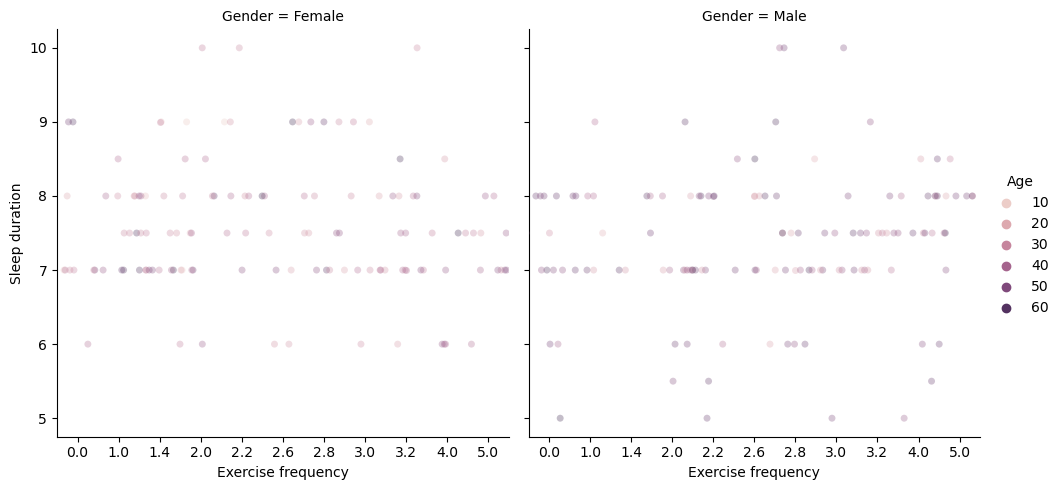

In [249]:

sns.catplot(data=sleep, x='Exercise frequency',y='Sleep duration',col='Gender',hue='Age',alpha=.3,jitter=10)


<Axes: xlabel='Exercise frequency', ylabel='Sleep duration'>

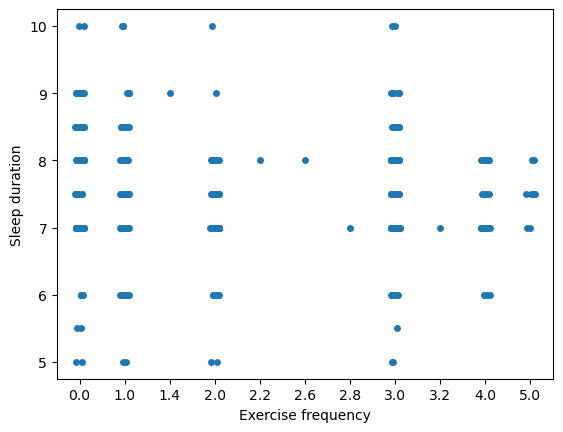

In [242]:
sns.catplot(x=sleep['Exercise frequency'],y=sleep['Sleep duration'],col='')

/Users/williammohr/opt/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:712: UserWarning: Using the stripplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/Users/williammohr/opt/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


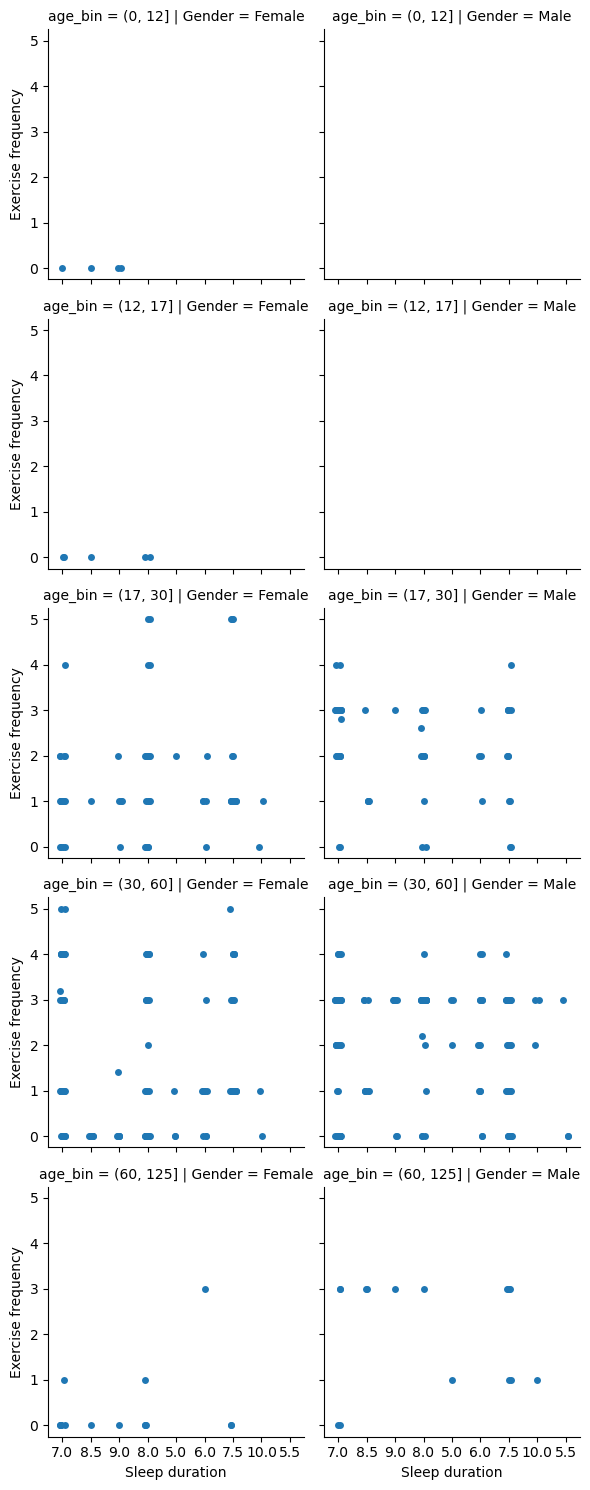

In [234]:
# g = sns.FacetGrid(sleep, col='Gender',  row='age_bin')
# g.map(sns.stripplot, "Sleep duration", "Exercise frequency")


In [227]:
sleep['Smoking status'].value_counts()

Smoking status
0    291
1    161
Name: count, dtype: int64

In [228]:
correlations_smoking = {}
for gender in ['Male','Female']:
    for age_bin in age_groups:
        goup = sleep[sleep.Gender==gender][(sleep.Age>=age_bin[1])&
                                          (sleep.Age<=age_bin[2])]
        correlations_smoking[f'{age_bin[0]}_{gender}']=np.round(goup.select_dtypes(include=\
                    [float,int]).corr().at['Smoking status','Sleep duration'],3)

/var/folders/7q/63cgxnn50sl5zwxkchv_j2cr0000gn/T/ipykernel_3866/1870487548.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  goup = sleep[sleep.Gender==gender][(sleep.Age>=age_bin[1])&
/var/folders/7q/63cgxnn50sl5zwxkchv_j2cr0000gn/T/ipykernel_3866/1870487548.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  goup = sleep[sleep.Gender==gender][(sleep.Age>=age_bin[1])&
/var/folders/7q/63cgxnn50sl5zwxkchv_j2cr0000gn/T/ipykernel_3866/1870487548.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  goup = sleep[sleep.Gender==gender][(sleep.Age>=age_bin[1])&
/var/folders/7q/63cgxnn50sl5zwxkchv_j2cr0000gn/T/ipykernel_3866/1870487548.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  goup = sleep[sleep.Gender==gender][(sleep.Age>=age_bin[1])&
/var/folders/7q/63cgxnn50sl5zwxkchv_j2cr0000gn/T/ipykernel_3866/1870487548.py:4: UserWarning: Boolean Series key will be rei

In [229]:
correlations_smoking

{'children_Male': nan,
 'teenagers_Male': nan,
 'young_adults_Male': -0.05,
 'adults_Male': 0.032,
 'older_adults_Male': 0.164,
 'children_Female': nan,
 'teenagers_Female': 0.25,
 'young_adults_Female': -0.091,
 'adults_Female': 0.139,
 'older_adults_Female': -0.805}

/Users/williammohr/opt/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


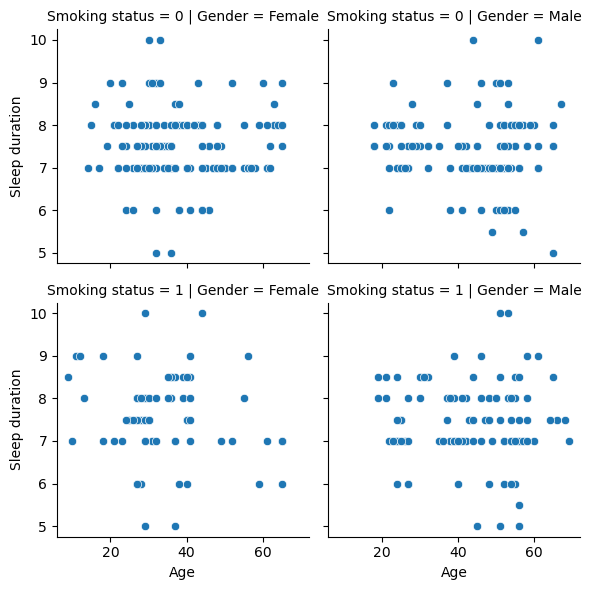

In [230]:
g = sns.FacetGrid(sleep, col='Gender',  row='Smoking status')
g.map(sns.scatterplot, "Age", "Sleep duration")


Text(0.5, 1.0, '')

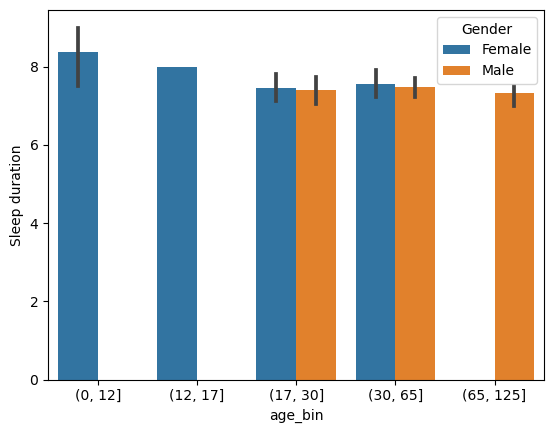

In [231]:
so.barplot(data=sleep[sleep['Smoking status']==1],x='age_bin', y= 'Sleep duration', hue='Gender')
plt.title('')